<a href="https://colab.research.google.com/github/DeerBay/Deep-Learning-Julia/blob/main/sequential_reward_shaping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Space Invaders with Deep Q-Learning and Reward Shaping
This notebook demonstrates a reinforcement learning project to train an agent to play Space Invaders using the Deep Q-Learning (DQN) algorithm. To enhance learning efficiency, reward shaping techniques are applied to guide the agent's behavior toward desired outcomes.

## Setup
The first few cells handle the installation of required libraries and the setup of Google Drive for saving models and logs. Ensure all dependencies are installed and paths are correctly set.

## Reward Shaping
The `RewardShaper` class adds domain knowledge to the reward signal. For instance, it:
- Encourages score improvements with small bonus rewards.
- Penalizes losing lives or inactivity.
- Incentivizes movement and shooting with balanced adjustments.

These modifications help guide the agent toward optimal behavior.

I've tried three different reward shapings here to examine wether it is possible to train the model for shorter time with effecient result.

## Deep Q-Learning Agent
The DQN agent uses a convolutional neural network to approximate the Q-value function. Key components include:
- **Network Architecture**: Three convolutional layers followed by a fully connected layer.
- **Action Selection**: Epsilon-greedy policy balances exploration and exploitation.
- **Target Network**: A separate target network helps stabilize Q-value updates.
- **Training**: The agent minimizes the Huber loss between predicted and target Q-values.

## Training Process
The main training loop involves resetting the environment, interacting with it using the agent's policy, and updating the Q-network using experience replay. Metrics such as shaped rewards, original rewards, and epsilon values are logged for analysis.

## Visualization
After each try I've generated a plot showing the training progress:
- **Average Reward**: Monitors the agent's performance over episodes.
- **Epsilon**: Tracks the exploration rate as it decays over time.

These insights help evaluate the effectiveness of the training and reward shaping techniques.

In [ ]:
!pip install 'gymnasium[atari, other]' gymnasium tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [21]:
import tensorflow as tf
from keras import layers
import gymnasium as gym
from gymnasium.wrappers import FrameStackObservation, AtariPreprocessing
import numpy as np
import os
import ale_py

class ReplayBuffer:
    def __init__(self, max_size, state_shape, num_actions):
        self.max_size = max_size
        self.states = np.zeros((max_size, *state_shape), dtype=np.float32)
        self.actions = np.zeros(max_size, dtype=np.int32)
        self.rewards = np.zeros(max_size, dtype=np.float32)
        self.next_states = np.zeros((max_size, *state_shape), dtype=np.float32)
        self.dones = np.zeros(max_size, dtype=np.float32)
        self.index = 0
        self.is_full = False

    def add(self, state, action, reward, next_state, done):
        idx = self.index % self.max_size
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.next_states[idx] = next_state
        self.dones[idx] = done
        self.index += 1
        if self.index >= self.max_size:
            self.is_full = True

    def sample(self, batch_size):
        max_index = self.max_size if self.is_full else self.index
        indices = np.random.choice(max_index, batch_size, replace=False)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices]
        )

    def __len__(self):
        return self.max_size if self.is_full else self.index

class RewardShaper:
    def __init__(self):
        self.previous_score = 0
        self.previous_lives = 3
        self.steps_since_last_shot = 0
        self.last_known_position = None
        self.consecutive_no_movement = 0

    def calculate_shaped_reward(self, info, reward, action, position):
        shaped_reward = reward  # Start with original reward

        # Track score improvements - reduced multiplier
        current_score = info.get('score', 0)
        if current_score > self.previous_score:
            score_improvement = current_score - self.previous_score
            shaped_reward += 0.05 * score_improvement  # Reduced from 0.1 to 0.05
            self.previous_score = current_score

        # Penalize death
        current_lives = info.get('lives', 3)
        if current_lives < self.previous_lives:
            shaped_reward -= 0.5
            self.previous_lives = current_lives

        # Movement-based shaping
        if self.last_known_position is not None:
            movement = abs(position - self.last_known_position)
            if movement < 0.005:
                self.consecutive_no_movement += 1
                if self.consecutive_no_movement > 15:
                    shaped_reward -= 0.05
            else:
                self.consecutive_no_movement = 0
                # Smaller movement reward
                shaped_reward += 0.005

        self.last_known_position = position

        # Shooting behavior shaping - more balanced
        if action == 1:  # Shoot action
            self.steps_since_last_shot = 0
            shaped_reward += 0.02  # Reduced from 0.05 to 0.02
        else:
            self.steps_since_last_shot += 1
            if self.steps_since_last_shot > 30:  # Increased from 20 to 30
                shaped_reward -= 0.02  # Reduced from 0.05 to 0.02

        # Ensure reward doesn't go too negative
        return max(-0.5, shaped_reward)  # Add a floor to prevent extreme negative rewards

class DQNAgent:
    def __init__(self, state_shape, num_actions, learning_rate=0.00025):
        self.state_shape = state_shape
        self.num_actions = num_actions
        self.model = self.create_q_model(state_shape, num_actions)
        self.target_model = self.create_q_model(state_shape, num_actions)
        self.target_model.set_weights(self.model.get_weights())
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
        self.replay_buffer = ReplayBuffer(max_size=100000, state_shape=state_shape, num_actions=num_actions)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_max = 1.0
        self.epsilon_random_frames = 10000  # Initial random frames
        self.epsilon_greedy_frames = 100000.0  # Total frames over which to decay epsilon

    def create_q_model(self, input_shape, num_actions):
        return tf.keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=8, strides=4, activation="relu", kernel_initializer='he_uniform'),
            layers.Conv2D(64, kernel_size=4, strides=2, activation="relu", kernel_initializer='he_uniform'),
            layers.Conv2D(64, kernel_size=3, strides=1, activation="relu", kernel_initializer='he_uniform'),
            layers.Flatten(),
            layers.Dense(512, activation="relu", kernel_initializer='he_uniform'),
            layers.Dense(num_actions, activation="linear")
        ])

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.num_actions)
        state_tensor = tf.convert_to_tensor(state[np.newaxis, ...], dtype=tf.float32)
        q_values = self.model(state_tensor, training=False)
        return tf.argmax(q_values[0]).numpy()

    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones):
        future_rewards = self.target_model(next_states, training=False)
        target_q_values = rewards + self.gamma * tf.reduce_max(future_rewards, axis=1) * (1 - dones)
        with tf.GradientTape() as tape:
            q_values = self.model(states, training=True)
            q_action = tf.reduce_sum(tf.one_hot(actions, self.num_actions) * q_values, axis=1)
            loss = tf.keras.losses.Huber()(target_q_values, q_action)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

def get_agent_position(state):
    """Extract the agent's position from the state"""
    bottom_slice = state[-10:, :, -1]  # Look at the bottom portion of the last frame
    agent_x = np.mean(np.where(bottom_slice > 0.5)[1]) if np.any(bottom_slice > 0.5) else None
    if agent_x is not None:
        return agent_x / state.shape[1]  # Normalize position
    return 0.5  # Return center if agent not found

def main():
    # Paths for saving
    model_dir = "/content/drive/MyDrive/SpaceInvaders/models"
    plot_dir = "/content/drive/MyDrive/SpaceInvaders/plots"
    log_dir = "/content/drive/MyDrive/SpaceInvaders/logs"
    log_file_path = os.path.join(log_dir, "training_log.txt")

    # Create all necessary directories
    for directory in [model_dir, plot_dir, log_dir]:
        os.makedirs(directory, exist_ok=True)

    # Environment setup
    gym.register_envs(ale_py)
    env = gym.make("SpaceInvadersNoFrameskip-v4", render_mode="rgb_array")
    env = AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True)
    env = FrameStackObservation(env, stack_size=4)

    # Agent and reward shaper setup
    state_shape = (84, 84, 4)
    num_actions = env.action_space.n
    agent = DQNAgent(state_shape, num_actions)
    reward_shaper = RewardShaper()

    # Training parameters
    max_episodes = 750  # Reduced from 2000
    max_steps_per_episode = 3000
    update_target_every = 1000
    log_every = 1
    episode_rewards = []
    frame_count = 0
    best_avg_reward = -float('inf')

    with open(log_file_path, "w") as f:
        f.write("Episode,Avg_Reward,Epsilon,Original_Reward,Shaped_Reward\n")

    # Training loop
    for episode in range(max_episodes):
        state, info = env.reset()
        state = np.array(state, dtype=np.float32) / 255.0
        state = np.transpose(state, (1, 2, 0))
        episode_reward = 0
        episode_original_reward = 0
        episode_steps = 0

        for step in range(max_steps_per_episode):
            frame_count += 1
            episode_steps += 1

            # Choose action
            if frame_count < agent.epsilon_random_frames:
                action = np.random.randint(num_actions)
            else:
                action = agent.get_action(state)

            # Step environment
            next_state, reward, done, _, info = env.step(action)
            next_state = np.array(next_state, dtype=np.float32) / 255.0
            next_state = np.transpose(next_state, (1, 2, 0))

            # Shape the reward
            agent_position = get_agent_position(state)
            shaped_reward = reward_shaper.calculate_shaped_reward(info, reward, action, agent_position)

            # Store original reward for logging
            episode_original_reward += reward
            episode_reward += shaped_reward

            # Store in replay buffer
            agent.replay_buffer.add(state, action, shaped_reward, next_state, done)
            state = next_state

            # Train
            if len(agent.replay_buffer) >= 32:
                states, actions, rewards, next_states, dones = agent.replay_buffer.sample(32)
                agent.train_step(states, actions, rewards, next_states, dones)

            # Update target model
            if frame_count % update_target_every == 0:
                agent.update_target_model()

            if done:
                break

        # Episode-based epsilon decay
        if frame_count >= agent.epsilon_random_frames:
            decay_per_episode = (agent.epsilon_max - agent.epsilon_min) / (max_episodes * 0.3)  # Decay over first 30% of episodes
            agent.epsilon = max(agent.epsilon_min, agent.epsilon - decay_per_episode)

        episode_rewards.append(episode_reward)
        avg_reward = np.mean(episode_rewards[-log_every:])

        # Log both original and shaped rewards
        with open(log_file_path, "a") as f:
            f.write(f"{episode + 1},{avg_reward:.2f},{agent.epsilon:.4f},{episode_original_reward:.2f},{episode_reward:.2f}\n")

        print(f"Episode {episode + 1}, Avg Reward: {avg_reward:.2f}, Original Reward: {episode_original_reward:.2f}, "
              f"Shaped Reward: {episode_reward:.2f}, Epsilon: {agent.epsilon:.4f}, Frame Count: {frame_count}, "
              f"Steps: {episode_steps}")

        # Save model conditionally
        if (episode + 1) % 100 == 0 or avg_reward > best_avg_reward:
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                print(f"New best average reward: {best_avg_reward:.2f}. Saving best model.")
            agent.model.save(f"{model_dir}/episode{episode + 1}_space_invaders_model.keras")

    # Save final model
    agent.model.save(f"{model_dir}/final_space_invaders_model.keras")

if __name__ == "__main__":
    main()


Episode 1, Avg Reward: 11.70, Original Reward: 50.00, Shaped Reward: 11.70, Epsilon: 1.0000, Frame Count: 389, Steps: 389
New best average reward: 11.70. Saving best model.
Episode 2, Avg Reward: 149.50, Original Reward: 210.00, Shaped Reward: 149.50, Epsilon: 1.0000, Frame Count: 1042, Steps: 653
New best average reward: 149.50. Saving best model.
Episode 3, Avg Reward: 13.85, Original Reward: 50.00, Shaped Reward: 13.85, Epsilon: 1.0000, Frame Count: 1428, Steps: 386
Episode 4, Avg Reward: 113.90, Original Reward: 170.00, Shaped Reward: 113.90, Epsilon: 1.0000, Frame Count: 2041, Steps: 613
Episode 5, Avg Reward: 17.20, Original Reward: 45.00, Shaped Reward: 17.20, Epsilon: 1.0000, Frame Count: 2340, Steps: 299
Episode 6, Avg Reward: 88.50, Original Reward: 135.00, Shaped Reward: 88.50, Epsilon: 1.0000, Frame Count: 2832, Steps: 492
Episode 7, Avg Reward: -27.55, Original Reward: 10.00, Shaped Reward: -27.55, Epsilon: 1.0000, Frame Count: 3220, Steps: 388
Episode 8, Avg Reward: 63.75

Plot saved at: /content/drive/MyDrive/SpaceInvaders/plots/training_log_plot_1.png
Total Episodes: 713

Reward Statistics:
Minimum Reward: -27.55
Maximum Reward: 1003.80
Mean Reward: 207.78
Median Reward: 179.55

Epsilon Statistics:
Initial Epsilon: 1.0000
Final Epsilon: 0.1000


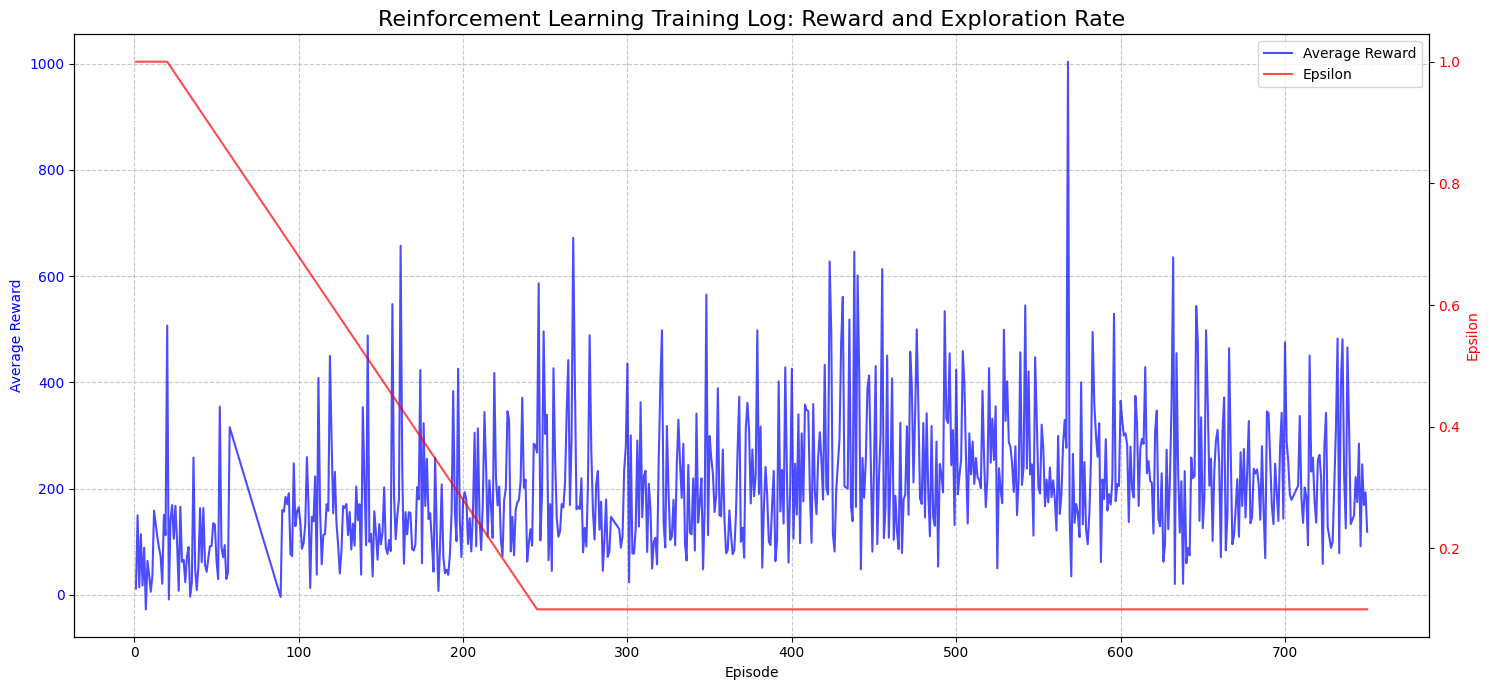

In [25]:
import pandas as pd
import matplotlib as plt

filepath ='/content/drive/MyDrive/SpaceInvaders/logs/training_log.txt'

df = pd.read_csv(filepath, sep=',')

# Directory to save the plot
save_path = '/content/drive/MyDrive/SpaceInvaders/plots/training_log_plot_1.png'

import matplotlib.pyplot as plt

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot Average Reward on the primary y-axis
color1 = 'blue'
ax1.set_xlabel('Episode')
ax1.set_ylabel('Average Reward', color=color1)
ax1.plot(df['Episode'], df['Avg_Reward'], color=color1, alpha=0.7, label='Average Reward')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a secondary y-axis for Epsilon
ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel('Epsilon', color=color2)
ax2.plot(df['Episode'], df['Epsilon'], color=color2, alpha=0.7, label='Epsilon')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('Reinforcement Learning Training Log: Reward and Exploration Rate', fontsize=16)
fig.tight_layout()

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Grid for better readability
ax1.grid(True, linestyle='--', alpha=0.7)

# Save the plot
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved at: {save_path}")

# Optional: Calculate and print some statistics
print(f"Total Episodes: {len(df)}")
print(f"\nReward Statistics:")
print(f"Minimum Reward: {df['Avg_Reward'].min():.2f}")
print(f"Maximum Reward: {df['Avg_Reward'].max():.2f}")
print(f"Mean Reward: {df['Avg_Reward'].mean():.2f}")
print(f"Median Reward: {df['Avg_Reward'].median():.2f}")

print(f"\nEpsilon Statistics:")
print(f"Initial Epsilon: {df['Epsilon'].iloc[0]:.4f}")
print(f"Final Epsilon: {df['Epsilon'].iloc[-1]:.4f}")

# Show the plot (optional, depends on your environment)
plt.show()

In [33]:

import tensorflow as tf
from keras import layers
import gymnasium as gym
from gymnasium.wrappers import FrameStackObservation, AtariPreprocessing
import numpy as np
import os
import ale_py
import matplotlib as plt

class ReplayBuffer:
    def __init__(self, max_size, state_shape, num_actions):
        self.max_size = max_size
        self.states = np.zeros((max_size, *state_shape), dtype=np.float32)
        self.actions = np.zeros(max_size, dtype=np.int32)
        self.rewards = np.zeros(max_size, dtype=np.float32)
        self.next_states = np.zeros((max_size, *state_shape), dtype=np.float32)
        self.dones = np.zeros(max_size, dtype=np.float32)
        self.index = 0
        self.is_full = False

    def add(self, state, action, reward, next_state, done):
        idx = self.index % self.max_size
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.next_states[idx] = next_state
        self.dones[idx] = done
        self.index += 1
        if self.index >= self.max_size:
            self.is_full = True

    def sample(self, batch_size):
        max_index = self.max_size if self.is_full else self.index
        indices = np.random.choice(max_index, batch_size, replace=False)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices]
        )

    def __len__(self):
        return self.max_size if self.is_full else self.index

class RewardShaper:
    def __init__(self):
        self.previous_score = 0
        self.previous_lives = 3
        self.steps_since_last_shot = 0
        self.last_known_position = None
        self.consecutive_no_movement = 0

    def calculate_shaped_reward(self, info, reward, action, position):
        shaped_reward = reward  # Start with original reward

        # Track score improvements - reduced multiplier
        current_score = info.get('score', 0)
        if current_score > self.previous_score:
            score_improvement = current_score - self.previous_score
            shaped_reward += 0.05 * score_improvement  # Reduced from 0.1 to 0.05
            self.previous_score = current_score

        # Penalize death - made less punitive
        current_lives = info.get('lives', 3)
        if current_lives < self.previous_lives:
            shaped_reward -= 0.5  # Reduced from 1.0 to 0.5
            self.previous_lives = current_lives

        # Movement-based shaping - more lenient thresholds
        if self.last_known_position is not None:
            movement = abs(position - self.last_known_position)
            if movement < 0.005:  # Reduced threshold from 0.01 to 0.005
                self.consecutive_no_movement += 1
                if self.consecutive_no_movement > 15:  # Increased from 10 to 15
                    shaped_reward -= 0.05  # Reduced penalty from 0.1 to 0.05
            else:
                self.consecutive_no_movement = 0
                # Smaller movement reward
                shaped_reward += 0.005  # Reduced from 0.01 to 0.005

        self.last_known_position = position

        # Shooting behavior shaping - more balanced
        if action == 1:  # Shoot action
            self.steps_since_last_shot = 0
            shaped_reward += 0.02  # Reduced from 0.05 to 0.02
        else:
            self.steps_since_last_shot += 1
            if self.steps_since_last_shot > 30:  # Increased from 20 to 30
                shaped_reward -= 0.02  # Reduced from 0.05 to 0.02

        # Ensure reward doesn't go too negative
        return max(-0.5, shaped_reward)  # Add a floor to prevent extreme negative rewards


class DQNAgent:
    def __init__(self, state_shape, num_actions, learning_rate=0.00025):
        self.state_shape = state_shape
        self.num_actions = num_actions
        self.model = self.create_q_model(state_shape, num_actions)
        self.target_model = self.create_q_model(state_shape, num_actions)
        self.target_model.set_weights(self.model.get_weights())
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
        self.replay_buffer = ReplayBuffer(max_size=100000, state_shape=state_shape, num_actions=num_actions)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_max = 1.0
        self.epsilon_random_frames = 50000  # Initial random frames
        self.epsilon_greedy_frames = 500000.0  # Total frames over which to decay epsilon

    def create_q_model(self, input_shape, num_actions):
        return tf.keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=8, strides=4, activation="relu", kernel_initializer='he_uniform'),
            layers.Conv2D(64, kernel_size=4, strides=2, activation="relu", kernel_initializer='he_uniform'),
            layers.Conv2D(64, kernel_size=3, strides=1, activation="relu", kernel_initializer='he_uniform'),
            layers.Flatten(),
            layers.Dense(512, activation="relu", kernel_initializer='he_uniform'),
            layers.Dense(num_actions, activation="linear")
        ])

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.num_actions)
        state_tensor = tf.convert_to_tensor(state[np.newaxis, ...], dtype=tf.float32)
        q_values = self.model(state_tensor, training=False)
        return tf.argmax(q_values[0]).numpy()

    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones):
        future_rewards = self.target_model(next_states, training=False)
        target_q_values = rewards + self.gamma * tf.reduce_max(future_rewards, axis=1) * (1 - dones)
        with tf.GradientTape() as tape:
            q_values = self.model(states, training=True)
            q_action = tf.reduce_sum(tf.one_hot(actions, self.num_actions) * q_values, axis=1)
            loss = tf.keras.losses.Huber()(target_q_values, q_action)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

def get_agent_position(state):
    """Extract the agent's position from the state"""
    bottom_slice = state[-10:, :, -1]  # Look at the bottom portion of the last frame
    agent_x = np.mean(np.where(bottom_slice > 0.5)[1]) if np.any(bottom_slice > 0.5) else None
    if agent_x is not None:
        return agent_x / state.shape[1]  # Normalize position
    return 0.5  # Return center if agent not found

def main():
    # Paths for saving
    model_dir = "/content/drive/MyDrive/SpaceInvaders/models_2"
    plot_dir = "/content/drive/MyDrive/SpaceInvaders/plots_2"
    log_dir = "/content/drive/MyDrive/SpaceInvaders/logs_2"
    log_file_path = os.path.join(log_dir, "training_log_2.txt")

    # Create all necessary directories
    for directory in [model_dir, plot_dir, log_dir]:
        os.makedirs(directory, exist_ok=True)

    # Environment setup
    gym.register_envs(ale_py)
    env = gym.make("SpaceInvadersNoFrameskip-v4", render_mode="rgb_array")
    env = AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True)
    env = FrameStackObservation(env, stack_size=4)

    # Agent and reward shaper setup
    state_shape = (84, 84, 4)
    num_actions = env.action_space.n
    agent = DQNAgent(state_shape, num_actions)
    reward_shaper = RewardShaper()

    # Training parameters
    max_episodes = 1000  # Reduced from 2000
    max_steps_per_episode = 3000
    update_target_every = 1000
    log_every = 1
    episode_rewards = []
    frame_count = 0
    best_avg_reward = -float('inf')

    with open(log_file_path, "w") as f:
        f.write("Episode,Avg_Reward,Epsilon,Original_Reward,Shaped_Reward\n")

    # Training loop
    for episode in range(max_episodes):
        state, info = env.reset()
        state = np.array(state, dtype=np.float32) / 255.0
        state = np.transpose(state, (1, 2, 0))
        episode_reward = 0
        episode_original_reward = 0
        episode_steps = 0

        for step in range(max_steps_per_episode):
            frame_count += 1
            episode_steps += 1

            # Choose action
            if frame_count < agent.epsilon_random_frames:
                action = np.random.randint(num_actions)
            else:
                action = agent.get_action(state)

            # Step environment
            next_state, reward, done, _, info = env.step(action)
            next_state = np.array(next_state, dtype=np.float32) / 255.0
            next_state = np.transpose(next_state, (1, 2, 0))

            # Shape the reward
            agent_position = get_agent_position(state)
            shaped_reward = reward_shaper.calculate_shaped_reward(info, reward, action, agent_position)

            # Store original reward for logging
            episode_original_reward += reward
            episode_reward += shaped_reward

            # Store in replay buffer
            agent.replay_buffer.add(state, action, shaped_reward, next_state, done)
            state = next_state

            # Train
            if len(agent.replay_buffer) >= 32:
                states, actions, rewards, next_states, dones = agent.replay_buffer.sample(32)
                agent.train_step(states, actions, rewards, next_states, dones)

            # Update target model
            if frame_count % update_target_every == 0:
                agent.update_target_model()

            if done:
                break

        # Episode-based epsilon decay
        if frame_count >= agent.epsilon_random_frames:
            decay_per_episode = (agent.epsilon_max - agent.epsilon_min) / (max_episodes * 0.7)  # Decay over first 70% of episodes
            agent.epsilon = max(agent.epsilon_min, agent.epsilon - decay_per_episode)

        episode_rewards.append(episode_reward)
        avg_reward = np.mean(episode_rewards[-log_every:])

        # Log both original and shaped rewards
        with open(log_file_path, "a") as f:
            f.write(f"{episode + 1},{avg_reward:.2f},{agent.epsilon:.4f},{episode_original_reward:.2f},{episode_reward:.2f},{frame_count}\n")


        # Save model conditionally
        if (episode + 1) % 100 == 0 or avg_reward > best_avg_reward:
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                print(f"New best average reward: {best_avg_reward:.2f}. Saving best model.")
            agent.model.save(f"{model_dir}/episode{episode + 1}_space_invaders_model.keras")
            print(f"Episode {episode + 1}, Avg Reward: {avg_reward:.2f}, Original Reward: {episode_original_reward:.2f}, "
              f"Shaped Reward: {episode_reward:.2f}, Epsilon: {agent.epsilon:.4f}, Frame Count: {frame_count} ")

    # Save final model
    agent.model.save(f"{model_dir}/final_space_invaders_model.keras")
    print(f"Episode {episode + 1}, Avg Reward: {avg_reward:.2f}, Original Reward: {episode_original_reward:.2f}, "
              f"Shaped Reward: {episode_reward:.2f}, Epsilon: {agent.epsilon:.4f}, Frame Count: {frame_count} ")

if __name__ == "__main__":
    main()

New best average reward: 20.85. Saving best model.
Episode 1, Avg Reward: 20.85, Original Reward: 35.00, Shaped Reward: 20.85, Epsilon: 1.0000, Frame Count: 296 
New best average reward: 115.54. Saving best model.
Episode 2, Avg Reward: 115.54, Original Reward: 140.00, Shaped Reward: 115.54, Epsilon: 1.0000, Frame Count: 826 
New best average reward: 669.73. Saving best model.
Episode 3, Avg Reward: 669.73, Original Reward: 715.00, Shaped Reward: 669.73, Epsilon: 1.0000, Frame Count: 1787 
New best average reward: 682.51. Saving best model.
Episode 84, Avg Reward: 682.51, Original Reward: 715.00, Shaped Reward: 682.51, Epsilon: 1.0000, Frame Count: 43482 
Episode 100, Avg Reward: 148.48, Original Reward: 180.00, Shaped Reward: 148.48, Epsilon: 0.9958, Frame Count: 51890 
Episode 200, Avg Reward: 121.34, Original Reward: 145.00, Shaped Reward: 121.34, Epsilon: 0.8543, Frame Count: 103800 
Episode 300, Avg Reward: 116.99, Original Reward: 135.00, Shaped Reward: 116.99, Epsilon: 0.7129, F

<ipython-input-24-02568f86e22e>:8: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filepath, sep=',', index_col=False)


Plot saved at: /content/drive/MyDrive/SpaceInvaders/plots_2/training_log_plot.png
Total Episodes: 976

Reward Statistics:
Minimum Reward: 2.45
Maximum Reward: 834.24
Mean Reward: 206.75
Median Reward: 178.39

Epsilon Statistics:
Initial Epsilon: 1.0000
Final Epsilon: 0.0100


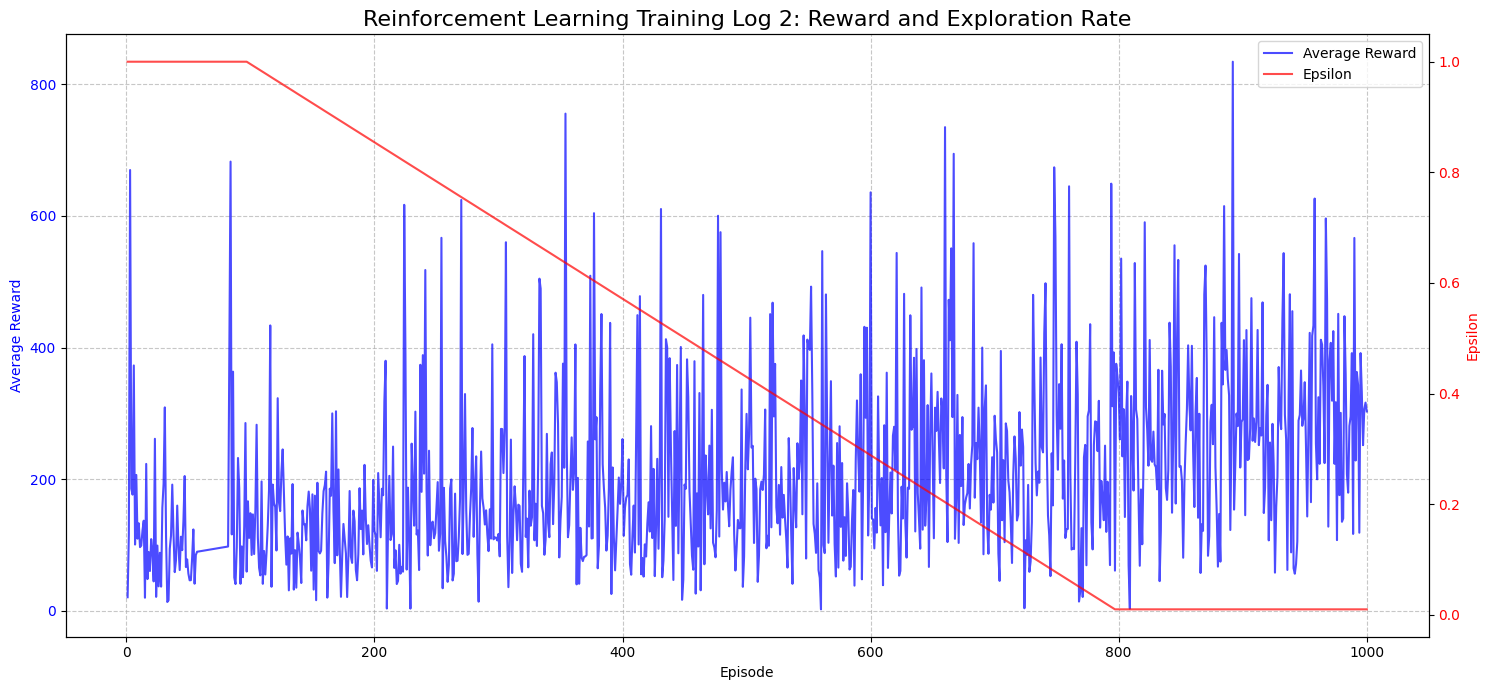

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# File path to your log file
filepath = '/content/drive/MyDrive/SpaceInvaders/logs_2/training_log_2.txt'

# Read the data
df = pd.read_csv(filepath, sep=',', index_col=False)

# Directory to save the plot
save_path = '/content/drive/MyDrive/SpaceInvaders/plots_2/training_log_plot_2.png'

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot Average Reward on the primary y-axis
color1 = 'blue'
ax1.set_xlabel('Episode')
ax1.set_ylabel('Average Reward', color=color1)
ax1.plot(df['Episode'], df['Avg_Reward'], color=color1, alpha=0.7, label='Average Reward')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a secondary y-axis for Epsilon
ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel('Epsilon', color=color2)
ax2.plot(df['Episode'], df['Epsilon'], color=color2, alpha=0.7, label='Epsilon')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('Reinforcement Learning Training Log 2: Reward and Exploration Rate', fontsize=16)
fig.tight_layout()

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Grid for better readability
ax1.grid(True, linestyle='--', alpha=0.7)

# Save the plot
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved at: {save_path}")

# Optional: Calculate and print some statistics
print(f"Total Episodes: {len(df)}")
print(f"\nReward Statistics:")
print(f"Minimum Reward: {df['Avg_Reward'].min():.2f}")
print(f"Maximum Reward: {df['Avg_Reward'].max():.2f}")
print(f"Mean Reward: {df['Avg_Reward'].mean():.2f}")
print(f"Median Reward: {df['Avg_Reward'].median():.2f}")

print(f"\nEpsilon Statistics:")
print(f"Initial Epsilon: {df['Epsilon'].iloc[0]:.4f}")
print(f"Final Epsilon: {df['Epsilon'].iloc[-1]:.4f}")

# Show the plot (optional, depends on your environment)
plt.show()

In [26]:

import tensorflow as tf
from keras import layers
import gymnasium as gym
from gymnasium.wrappers import FrameStackObservation, AtariPreprocessing
import numpy as np
import os
import ale_py
import matplotlib as plt

class ReplayBuffer:
    def __init__(self, max_size, state_shape, num_actions):
        self.max_size = max_size
        self.states = np.zeros((max_size, *state_shape), dtype=np.float32)
        self.actions = np.zeros(max_size, dtype=np.int32)
        self.rewards = np.zeros(max_size, dtype=np.float32)
        self.next_states = np.zeros((max_size, *state_shape), dtype=np.float32)
        self.dones = np.zeros(max_size, dtype=np.float32)
        self.index = 0
        self.is_full = False

    def add(self, state, action, reward, next_state, done):
        idx = self.index % self.max_size
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.next_states[idx] = next_state
        self.dones[idx] = done
        self.index += 1
        if self.index >= self.max_size:
            self.is_full = True

    def sample(self, batch_size):
        max_index = self.max_size if self.is_full else self.index
        indices = np.random.choice(max_index, batch_size, replace=False)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices]
        )

    def __len__(self):
        return self.max_size if self.is_full else self.index

class RewardShaper:
    def __init__(self):
        self.previous_score = 0
        self.previous_lives = 3
        self.steps_since_last_shot = 0
        self.last_known_position = None
        self.consecutive_no_movement = 0

    def calculate_shaped_reward(self, info, reward, action, position):
      shaped_reward = reward  # Start with original reward

      # Track score improvements - reduced multiplier
      current_score = info.get('score', 0)
      if current_score > self.previous_score:
          score_improvement = current_score - self.previous_score
          shaped_reward += 0.05 * score_improvement  # Reduced from 0.1 to 0.05
          self.previous_score = current_score

      # Penalize death - made less punitive
      current_lives = info.get('lives', 3)
      if current_lives < self.previous_lives:
          shaped_reward -= 0.5  # Reduced from 1.0 to 0.5
          self.previous_lives = current_lives

      # Movement-based shaping - more lenient thresholds
      if self.last_known_position is not None:
          movement = abs(position - self.last_known_position)
          if movement < 0.005:  # Reduced threshold from 0.01 to 0.005
              self.consecutive_no_movement += 1
              if self.consecutive_no_movement > 15:  # Increased from 10 to 15
                  shaped_reward -= 0.05  # Reduced penalty from 0.1 to 0.05
          else:
              self.consecutive_no_movement = 0
              # Smaller movement reward
              shaped_reward += 0.005  # Reduced from 0.01 to 0.005

      self.last_known_position = position

      # Shooting behavior shaping - more balanced
      if action == 1:  # Shoot action
          self.steps_since_last_shot = 0
          if info.get('hit', False):  # Reward successful hits
              shaped_reward += 0.1
              if info.get('target_is_back_row', False):
                  shaped_reward += 0.2  # Additional bonus for back-row targets
              if info.get('target_is_ufo', False):
                  shaped_reward += 0.2  # Additional bonus for UFO hits
          else:
              shaped_reward -= 0.05  # Penalize missed shots
      else:
          self.steps_since_last_shot += 1
          if self.steps_since_last_shot > 30:  # Increased from 20 to 30
              shaped_reward -= 0.02  # Reduced from 0.05 to 0.02

      # Column clearing incentive
      if info.get('cleared_column', False):
          shaped_reward += 0.2  # Reward for clearing a column

      # Shield usage shaping
      if info.get('near_shield', False) and not info.get('destroying_shield', False):
          shaped_reward += 0.05  # Incentive for smart shield use
      if info.get('destroying_shield', False):
          shaped_reward -= 0.1  # Penalty for damaging own shield

      # Dodge enemy bullets
      if info.get('dodged_bullet', False):
          shaped_reward += 0.1  # Bonus for successful evasion

      # Survival bonus for completing waves
      if info.get('survived_wave', False):
          shaped_reward += 0.3  # Bonus for wave survival

      # Efficiency bonus for faster wave clear
      if info.get('cleared_wave_faster_than_average', False):
          shaped_reward += 0.2  # Efficiency reward

      # Ensure reward doesn't go too negative
      return max(-0.5, shaped_reward)  # Add a floor to prevent extreme negative rewards



class DQNAgent:
    def __init__(self, state_shape, num_actions, learning_rate=0.00025):
        self.state_shape = state_shape
        self.num_actions = num_actions
        self.model = self.create_q_model(state_shape, num_actions)
        self.target_model = self.create_q_model(state_shape, num_actions)
        self.target_model.set_weights(self.model.get_weights())
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
        self.replay_buffer = ReplayBuffer(max_size=100000, state_shape=state_shape, num_actions=num_actions)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_max = 1.0
        self.epsilon_random_frames = 50000  # Initial random frames
        self.epsilon_greedy_frames = 500000.0  # Total frames over which to decay epsilon

    def create_q_model(self, input_shape, num_actions):
        return tf.keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=8, strides=4, activation="relu", kernel_initializer='he_uniform'),
            layers.Conv2D(64, kernel_size=4, strides=2, activation="relu", kernel_initializer='he_uniform'),
            layers.Conv2D(64, kernel_size=3, strides=1, activation="relu", kernel_initializer='he_uniform'),
            layers.Flatten(),
            layers.Dense(512, activation="relu", kernel_initializer='he_uniform'),
            layers.Dense(num_actions, activation="linear")
        ])

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.num_actions)
        state_tensor = tf.convert_to_tensor(state[np.newaxis, ...], dtype=tf.float32)
        q_values = self.model(state_tensor, training=False)
        return tf.argmax(q_values[0]).numpy()

    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones):
        future_rewards = self.target_model(next_states, training=False)
        target_q_values = rewards + self.gamma * tf.reduce_max(future_rewards, axis=1) * (1 - dones)
        with tf.GradientTape() as tape:
            q_values = self.model(states, training=True)
            q_action = tf.reduce_sum(tf.one_hot(actions, self.num_actions) * q_values, axis=1)
            loss = tf.keras.losses.Huber()(target_q_values, q_action)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

def get_agent_position(state):
    """Extract the agent's position from the state"""
    bottom_slice = state[-10:, :, -1]  # Look at the bottom portion of the last frame
    agent_x = np.mean(np.where(bottom_slice > 0.5)[1]) if np.any(bottom_slice > 0.5) else None
    if agent_x is not None:
        return agent_x / state.shape[1]  # Normalize position
    return 0.5  # Return center if agent not found

def main():
    # Paths for saving
    model_dir = "/content/drive/MyDrive/SpaceInvaders/models_3"
    plot_dir = "/content/drive/MyDrive/SpaceInvaders/plots_3"
    log_dir = "/content/drive/MyDrive/SpaceInvaders/logs_3"
    log_file_path = os.path.join(log_dir, "training_log_3.txt")

    # Create all necessary directories
    for directory in [model_dir, plot_dir, log_dir]:
        os.makedirs(directory, exist_ok=True)

    # Environment setup
    gym.register_envs(ale_py)
    env = gym.make("SpaceInvadersNoFrameskip-v4", render_mode="rgb_array")
    env = AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True)
    env = FrameStackObservation(env, stack_size=4)

    # Agent and reward shaper setup
    state_shape = (84, 84, 4)
    num_actions = env.action_space.n
    agent = DQNAgent(state_shape, num_actions)
    reward_shaper = RewardShaper()

    # Training parameters
    max_episodes = 1000  # Reduced from 2000
    max_steps_per_episode = 3000
    update_target_every = 1000
    log_every = 1
    episode_rewards = []
    frame_count = 0
    best_avg_reward = -float('inf')

    with open(log_file_path, "w") as f:
        f.write("Episode,Avg_Reward,Epsilon,Original_Reward,Shaped_Reward\n")

    # Training loop
    for episode in range(max_episodes):
        state, info = env.reset()
        state = np.array(state, dtype=np.float32) / 255.0
        state = np.transpose(state, (1, 2, 0))
        episode_reward = 0
        episode_original_reward = 0
        episode_steps = 0

        for step in range(max_steps_per_episode):
            frame_count += 1
            episode_steps += 1

            # Choose action
            if frame_count < agent.epsilon_random_frames:
                action = np.random.randint(num_actions)
            else:
                action = agent.get_action(state)

            # Step environment
            next_state, reward, done, _, info = env.step(action)
            next_state = np.array(next_state, dtype=np.float32) / 255.0
            next_state = np.transpose(next_state, (1, 2, 0))

            # Shape the reward
            agent_position = get_agent_position(state)
            shaped_reward = reward_shaper.calculate_shaped_reward(info, reward, action, agent_position)

            # Store original reward for logging
            episode_original_reward += reward
            episode_reward += shaped_reward

            # Store in replay buffer
            agent.replay_buffer.add(state, action, shaped_reward, next_state, done)
            state = next_state

            # Train
            if len(agent.replay_buffer) >= 32:
                states, actions, rewards, next_states, dones = agent.replay_buffer.sample(32)
                agent.train_step(states, actions, rewards, next_states, dones)

            # Update target model
            if frame_count % update_target_every == 0:
                agent.update_target_model()

            if done:
                break

        # Episode-based epsilon decay
        if frame_count >= agent.epsilon_random_frames:
            decay_per_episode = (agent.epsilon_max - agent.epsilon_min) / (max_episodes * 0.7)  # Decay over first 70% of episodes
            agent.epsilon = max(agent.epsilon_min, agent.epsilon - decay_per_episode)

        episode_rewards.append(episode_reward)
        avg_reward = np.mean(episode_rewards[-log_every:])

        # Log both original and shaped rewards
        with open(log_file_path, "a") as f:
            f.write(f"{episode + 1},{avg_reward:.2f},{agent.epsilon:.4f},{episode_original_reward:.2f},{episode_reward:.2f},{frame_count}\n")


        # Save model conditionally
        if (episode + 1) % 100 == 0 or avg_reward > best_avg_reward:
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                print(f"New best average reward: {best_avg_reward:.2f}. Saving best model.")
            agent.model.save(f"{model_dir}/episode{episode + 1}_space_invaders_model.keras")
            print(f"Episode {episode + 1}, Avg Reward: {avg_reward:.2f}, Original Reward: {episode_original_reward:.2f}, "
              f"Shaped Reward: {episode_reward:.2f}, Epsilon: {agent.epsilon:.4f}, Frame Count: {frame_count} ")

    # Save final model
    agent.model.save(f"{model_dir}/final_space_invaders_model.keras")
    print(f"Episode {episode + 1}, Avg Reward: {avg_reward:.2f}, Original Reward: {episode_original_reward:.2f}, "
              f"Shaped Reward: {episode_reward:.2f}, Epsilon: {agent.epsilon:.4f}, Frame Count: {frame_count} ")

if __name__ == "__main__":
    main()

New best average reward: 226.60. Saving best model.
Episode 1, Avg Reward: 226.60, Original Reward: 260.00, Shaped Reward: 226.60, Epsilon: 1.0000, Frame Count: 574 
New best average reward: 355.40. Saving best model.
Episode 5, Avg Reward: 355.40, Original Reward: 395.00, Shaped Reward: 355.40, Epsilon: 1.0000, Frame Count: 2575 
New best average reward: 375.30. Saving best model.
Episode 9, Avg Reward: 375.30, Original Reward: 410.00, Shaped Reward: 375.30, Epsilon: 1.0000, Frame Count: 4931 
New best average reward: 389.10. Saving best model.
Episode 40, Avg Reward: 389.10, Original Reward: 425.00, Shaped Reward: 389.10, Epsilon: 1.0000, Frame Count: 19908 
New best average reward: 437.13. Saving best model.
Episode 44, Avg Reward: 437.13, Original Reward: 485.00, Shaped Reward: 437.13, Epsilon: 1.0000, Frame Count: 22194 
Episode 100, Avg Reward: 101.00, Original Reward: 130.00, Shaped Reward: 101.00, Epsilon: 0.9915, Frame Count: 52498 
New best average reward: 512.25. Saving best

<ipython-input-27-9b658b55124f>:8: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filepath, sep=',', index_col=False)


Plot saved at: /content/drive/MyDrive/SpaceInvaders/plots_3/training_log_plot_3.png
Total Episodes: 1000

Reward Statistics:
Minimum Reward: -17.60
Maximum Reward: 631.96
Mean Reward: 150.79
Median Reward: 126.97

Epsilon Statistics:
Initial Epsilon: 1.0000
Final Epsilon: 0.0100


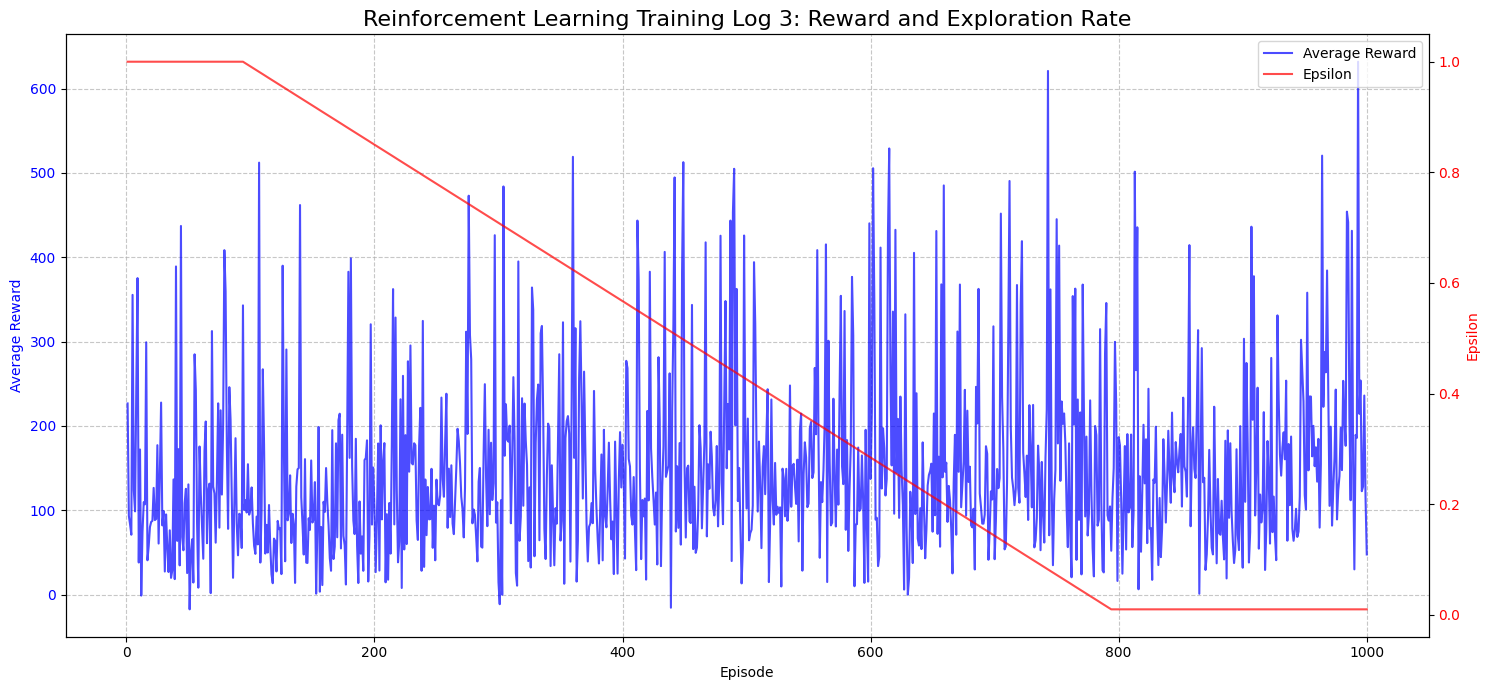

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# File path to your log file
filepath = '/content/drive/MyDrive/SpaceInvaders/logs_3/training_log_3.txt'

# Read the data
df = pd.read_csv(filepath, sep=',', index_col=False)

# Directory to save the plot
save_path = '/content/drive/MyDrive/SpaceInvaders/plots_3/training_log_plot_3.png'

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot Average Reward on the primary y-axis
color1 = 'blue'
ax1.set_xlabel('Episode')
ax1.set_ylabel('Average Reward', color=color1)
ax1.plot(df['Episode'], df['Avg_Reward'], color=color1, alpha=0.7, label='Average Reward')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a secondary y-axis for Epsilon
ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel('Epsilon', color=color2)
ax2.plot(df['Episode'], df['Epsilon'], color=color2, alpha=0.7, label='Epsilon')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('Reinforcement Learning Training Log 3: Reward and Exploration Rate', fontsize=16)
fig.tight_layout()

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Grid for better readability
ax1.grid(True, linestyle='--', alpha=0.7)

# Save the plot
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved at: {save_path}")

# Optional: Calculate and print some statistics
print(f"Total Episodes: {len(df)}")
print(f"\nReward Statistics:")
print(f"Minimum Reward: {df['Avg_Reward'].min():.2f}")
print(f"Maximum Reward: {df['Avg_Reward'].max():.2f}")
print(f"Mean Reward: {df['Avg_Reward'].mean():.2f}")
print(f"Median Reward: {df['Avg_Reward'].median():.2f}")

print(f"\nEpsilon Statistics:")
print(f"Initial Epsilon: {df['Epsilon'].iloc[0]:.4f}")
print(f"Final Epsilon: {df['Epsilon'].iloc[-1]:.4f}")

# Show the plot
plt.show()